# NEURAL NETWORK TO PREDICT CARDIOVASCULAR DISEASES

###### *To see our info page (about cardiovascular diseases and info about us), you could visit : https://mailchi.mp/dd56c857ba2e/heartaid*

### Uploading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['weights-nn', 'cardiovascular-disease-dataset']


### Uploading data

In [2]:
data=pd.read_csv("../input/cardiovascular-disease-dataset/cardio_train.csv")
df=data.from_csv("../input/cardiovascular-disease-dataset/cardio_train.csv", header=0, sep=";")
dfcol=df.columns
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


age  gender  height  weight   ...    smoke  alco  active  cardio
id                                  ...                               
0   18393       2     168    62.0   ...        0     0       1       0
1   20228       1     156    85.0   ...        0     0       1       1
2   18857       1     165    64.0   ...        0     0       0       1
3   17623       2     169    82.0   ...        0     0       1       1
4   17474       1     156    56.0   ...        0     0       0       0

[5 rows x 12 columns]

### Checking if the targets are balanced

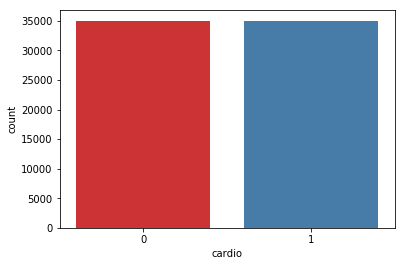

In [3]:
df[["cardio","height"]].groupby("cardio").count()
sns.countplot(x="cardio", data=df, palette="Set1")

### Data Transform (Scaling to avoid outliers)

In [4]:

from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
dfscale=scaler.fit_transform(df)
dfscale2=pd.DataFrame(dfscale, columns=dfcol)
dfscale2.head()

age  gender    height    weight   ...    smoke  alco  active  cardio
0  0.588076     1.0  0.579487  0.273684   ...      0.0   0.0     1.0     0.0
1  0.730159     0.0  0.517949  0.394737   ...      0.0   0.0     1.0     1.0
2  0.624003     0.0  0.564103  0.284211   ...      0.0   0.0     0.0     1.0
3  0.528455     1.0  0.584615  0.378947   ...      0.0   0.0     1.0     1.0
4  0.516918     0.0  0.517949  0.242105   ...      0.0   0.0     0.0     0.0

[5 rows x 12 columns]

### Splitting data

In [5]:
xdf=dfscale2.iloc[:,0:11]
#xdf["gender"]=np.where(xdf["gender"]==1,"0","1") #Cambiar el 2 por 1, el 1 por 0 (por orden)
#Aca vendria un posible drop de variables xdf=xdf.drop(["gender","gluc"], axis=1)
ydf=dfscale2.iloc[:,-1]


In [6]:
x_training, x_testing, y_training, y_testing = train_test_split(xdf, ydf, test_size = 0.2, random_state=123, stratify=ydf)

In [7]:
print(xdf.shape)

(70000, 11)


## Neural Network

#### Basic NN

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.constraints import maxnorm

model = Sequential()
model.add(Dense(25, input_dim=11, activation='softsign', kernel_constraint=maxnorm(2)))
#model.add(Dropout(0))
model.add(Dense(5, activation='softsign'))
#model.add(Dropout(0))
model.add(Dense(3, activation='softsign'))
#model.add(Dropout(0))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(x_training, y_training, epochs=50, batch_size=50, verbose=0)
score = model.evaluate(x_training, y_training)
print("\n Training Accuracy:", score[1])
score = model.evaluate(x_testing, y_testing)
print("\n Testing Accuracy:", score[1])

56000/56000 [==============================] - 1s 18us/step

 Training Accuracy: 0.7065178571428572
14000/14000 [==============================] - 0s 17us/step

 Testing Accuracy: 0.7124285714285714


* **Initial Accuracy**= 0.6465 
* **Final aprox Accuracy**= 0.68-0.719

## Prediction

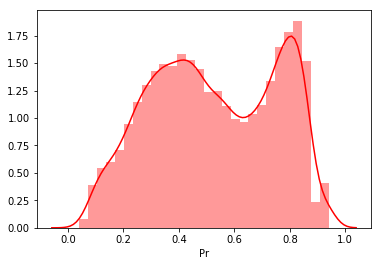

In [10]:
res=model.predict(x_testing)
res
resdf=pd.DataFrame(res, index=x_testing.index)
resdf.columns=["Pr"]
resdf["ID"]=range(14000)
resdf["y"]=np.where(resdf["Pr"]>=0.5,"1", "0")
resdf
prediction=resdf.drop(["Pr","ID"], axis=1)
predictionarray=prediction.astype(np.float)
sns.distplot(resdf["Pr"],  color="red")

#### How many 1's and 0's predict the model

In [11]:
c1=resdf[['ID','y']].groupby('y').count()
c1

ID
y      
0  6766
1  7234

#### How many 1's and 0's are in the test sample

In [12]:
y_testingdf=pd.DataFrame(y_testing, index=y_testing.index)
y_testingdf["ID"]=range(14000)
y_test=y_testingdf.drop(["ID"], axis=1)
c2=y_testingdf[['ID','cardio']].groupby('cardio').count()
c2

ID
cardio      
0.0     7004
1.0     6996

### Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.values, predictionarray)
cm

array([[4872, 2132],
       [1894, 5102]])

#### Accuracy of the Model

In [14]:
Accuracy=cm[0,0]/(cm[0,0]+cm[1,0])
print("The accuracy of the model is: "+ str(Accuracy*100) + " %")

The accuracy of the model is: 72.00709429500444 %


This means that of all the people with Cardiovascular Disease in the Test-DataBase, the model identify **73% (aprox.)** of the total cases.

# Predicting a single case

In [15]:
#INSERT DATA#
###############################################################################

day= 25 # day of bith 
month= 9 # month of bith (in numbers)
year= 1998 # year of bith
gender= 1 # 0 for women, 1 for men
height= 183 # in cm
weight= 89 # in kilograms
systolicbloodpressure= 120 # Systolic blood pressure
diastolicbloodpressure= 80 # Diastolic blood pressure
cholesterol= 1 # 1: normal, 2: above normal, 3: well above normal
gluc= 1 # 1: normal, 2: above normal, 3: well above normal
smoke= 0 # 1 if you smoke, 0 if not
alco= 0 # 1 if you drink alcohol, 0 if not
active= 1 # 1 if you do physical activity, 0 if not

##############################################################################
from datetime import date
f_date = date(year,month,day)
l_date = date.today()
delta = l_date - f_date
agedays=delta.days

agedayscale=(agedays-df["age"].min())/(df["age"].max()-df["age"].min())
heightscale=(height-df["height"].min())/(df["height"].max()-df["height"].min())
weightscale=(weight-df["weight"].min())/(df["weight"].max()-df["weight"].min())
sbpscale=(systolicbloodpressure-df["ap_hi"].min())/(df["ap_hi"].max()-df["ap_hi"].min())
dbpscale=(diastolicbloodpressure-df["ap_lo"].min())/(df["ap_lo"].max()-df["ap_lo"].min())
cholesterolscale=(cholesterol-df["cholesterol"].min())/(df["cholesterol"].max()-df["cholesterol"].min())
glucscale=(gluc-df["gluc"].min())/(df["gluc"].max()-df["gluc"].min())

single=np.array([agedayscale, gender, heightscale, weightscale, sbpscale, dbpscale, cholesterolscale, glucscale, smoke, alco, active ])
singledf=pd.DataFrame(single)
final=singledf.transpose()
final

0    1        2         3         4  ...    6    7    8    9    10
0 -0.248471  1.0  0.65641  0.415789  0.016698 ...   0.0  0.0  0.0  0.0  1.0

[1 rows x 11 columns]

finalres=model.predict(final)
finalres
print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(finalres[0,0]*100,2)) + "%")

In [16]:
from keras.models import model_from_json

#model.save_weights("weights.hdf5")
json_string = model.to_json()
modeltopredict = model_from_json(json_string)
modeltopredict.load_weights("../input/weights-nn/weights.hdf5", by_name=False)

prediction=modeltopredict.predict(final)

if prediction[0,0]>=0.5:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("You must visit a doctor to check it :(")
elif prediction[0,0]<0.5 and prediction[0,0]>=0.3:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("Probably you are healthy :/ ")
else:
    print("The probability of having or to have a Cardiovascular Disease is: "+ str(round(prediction[0,0]*100,2)) + "%")
    print("You are healthy :) ")

The probability of having or to have a Cardiovascular Disease is: 14.02%
You are healthy :) 


# Tuning hyperparameters to look up for the best NN

In [17]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Batch Size and Epochs

In the final kernel, this code is not gonna be available 'cause it takes too much time to run this parts of code.
The summary will be written below the function.

def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=11, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, verbose=0)

#### define the parameters to search in grid search 
batch_size = [10, 50, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:** 
* Best: 0.640893 using {**'batch_size': 50, 'epochs': 50**}
* 0.638214 (0.003997) with: {'batch_size': 10, 'epochs': 10}
* 0.640446 (0.006447) with: {'batch_size': 10, 'epochs': 50}
* 0.613500 (0.060568) with: {'batch_size': 10, 'epochs': 100}
* 0.617089 (0.012489) with: {'batch_size': 50, 'epochs': 10}
* 0.640893 (0.004402) with: {'batch_size': 50, 'epochs': 50}
* 0.640661 (0.003730) with: {'batch_size': 50, 'epochs': 100}
* 0.613732 (0.017299) with: {'batch_size': 100, 'epochs': 10}
* 0.635268 (0.005980) with: {'batch_size': 100, 'epochs': 50}
* 0.639482 (0.007552) with: {'batch_size': 100, 'epochs': 100}

## Optimization Algorithm

In the final kernel, this code is not gonna be available 'cause it takes too much time to run this parts of code.
The summary will be written below the function.

#### function to create model
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(10, input_dim=11, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

#### define the parameters to search in grid search 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:** 
* Best: 0.708232 using {**'optimizer': 'Nadam'**}
* 0.639339 (0.003833) with: {'optimizer': 'SGD'}
* 0.685446 (0.014199) with: {'optimizer': 'RMSprop'}
* 0.644750 (0.004682) with: {'optimizer': 'Adagrad'}
* 0.664732 (0.011830) with: {'optimizer': 'Adadelta'}
* 0.676821 (0.017248) with: {'optimizer': 'Adam'}
* 0.653625 (0.003463) with: {'optimizer': 'Adamax'}
* 0.708232 (0.010960) with: {'optimizer': 'Nadam'}

## Optimization of SGD algorithm (Learnig Rate and Momentum)

#### function to create model
def create_model(learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(10, input_dim=11, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

#### define the parameters to search in grid search 
learn_rate = [0.01, 0.1, 0.2]
momentum = [0.2, 0.6, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:** 
* Best: 0.642571 using {**'learn_rate': 0.01, 'momentum': 0.2**}
* 0.642571 (0.004326) with: {'learn_rate': 0.01, 'momentum': 0.2}
* 0.642375 (0.003565) with: {'learn_rate': 0.01, 'momentum': 0.6}
* 0.641786 (0.005498) with: {'learn_rate': 0.01, 'momentum': 0.9}
* 0.586232 (0.069370) with: {'learn_rate': 0.1, 'momentum': 0.2}
* 0.642089 (0.004087) with: {'learn_rate': 0.1, 'momentum': 0.6}
* 0.638589 (0.006434) with: {'learn_rate': 0.1, 'momentum': 0.9}
* 0.498554 (0.005800) with: {'learn_rate': 0.2, 'momentum': 0.2}
* 0.587482 (0.071161) with: {'learn_rate': 0.2, 'momentum': 0.6}
* 0.594286 (0.058599) with: {'learn_rate': 0.2, 'momentum': 0.9}

## Activation functions

def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(10, input_dim=11, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer="Nadam", metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

#### define the parameters to search in grid search 
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:** 
* Best: 0.717250 using {**'activation': 'softsign'**}
* 0.649786 (0.005472) with: {'activation': 'softmax'}
* 0.649464 (0.005333) with: {'activation': 'softplus'}
* 0.717250 (0.006675) with: {'activation': 'softsign'}
* 0.701964 (0.021487) with: {'activation': 'relu'}
* 0.717179 (0.002289) with: {'activation': 'tanh'}
* 0.648446 (0.006001) with: {'activation': 'sigmoid'}
* 0.651750 (0.004286) with: {'activation': 'hard_sigmoid'}
* 0.709232 (0.015933) with: {'activation': 'linear'}

## Dropout Rate and Weight Constraint

from keras.layers import Dropout
from keras.constraints import maxnorm

#### function to create model
def create_model(dropout_rate=0.0, weight_constraint=0):
    model = Sequential()
    model.add(Dense(10, input_dim=11, activation='softsign', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softsign'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softsign'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

#### define the parameters to search in grid search 
weight_constraint = [0, 1, 2]
dropout_rate = [0.0, 0.1, 0.2]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:**
* Best: 0.701179 using {**'dropout_rate': 0.0, 'weight_constraint': 2**}
* 0.500839 (0.005918) with: {'dropout_rate': 0.0, 'weight_constraint': 0}
* 0.651839 (0.005446) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
* 0.701179 (0.010650) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
* 0.500446 (0.005961) with: {'dropout_rate': 0.1, 'weight_constraint': 0}
* 0.648250 (0.007944) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
* 0.684536 (0.022927) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
* 0.500304 (0.005970) with: {'dropout_rate': 0.2, 'weight_constraint': 0}
* 0.649732 (0.002889) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
* 0.666893 (0.011692) with: {'dropout_rate': 0.2, 'weight_constraint': 2}

## Number of neurons in the first layer

def create_model(neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=11, activation='softsign', kernel_constraint=maxnorm(2)))
    model.add(Dropout(0))
    model.add(Dense(5, activation='softsign'))
    model.add(Dropout(0))
    model.add(Dense(3, activation='softsign'))
    model.add(Dropout(0))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

#### create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=0)

#### define the parameters to search in grid search 
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_training, y_training)

#### summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

**Results:**
* Best: 0.703107 using {**'neurons': 25**}
* 0.683607 (0.003922) with: {'neurons': 1}
* 0.700411 (0.003911) with: {'neurons': 5}
* 0.694625 (0.009716) with: {'neurons': 10}
* 0.699536 (0.009807) with: {'neurons': 15}
* 0.698893 (0.013422) with: {'neurons': 20}
* 0.703107 (0.014787) with: {'neurons': 25}
* 0.688821 (0.026863) with: {'neurons': 30}